In [1]:
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

##################  Загрузка данных
Xtrain = pd.read_csv('D:\Coding\data\phone_user_review_file_60.csv', encoding= 'utf-8')
Xtest = pd.read_csv('D:\Coding\data\phone_user_review_file_40.csv', encoding= 'utf-8')

In [2]:
print("Xtrain.shape(): ", Xtrain.shape,
      "\nXtest.shape(): ", Xtest.shape)

Xtrain.shape():  (163837, 11) 
Xtest.shape():  (98284, 11)


In [3]:
print("Xtrain.head():\n", Xtrain[['lang', 'score', 'extract']].head())

Xtrain.head():
   lang  score                                            extract
0   en    8.0  I've had the phone for awhile and it's a prett...
1   en    6.0  to be clear it is not the sellers fault that t...
2   en    9.0  Well i love this phone. i have had ton of phon...
3   en    4.0  I have had my Instinct for several months now ...
4   en    6.0  i have had this instinct phone for about two m...


In [4]:
##################  Препроцессинг

In [5]:
import nltk
nltk.download('stopwords')
from sklearn.metrics import mean_squared_error
import re #regular expressions
from nltk.corpus import stopwords #stopwords

import pymorphy2 #Для лемматизации
morph = pymorphy2.MorphAnalyzer()

#Добавление списка stopwords
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def review_to_wordlist(review):
    #1) - регулярное выражение к тексту
    review_text = re.sub("[^а-яА-Яa-zA-Z]"," ", review)
    #2) - разделение текста на список слов
    words = review_text.lower().split()
    #3) - удаление stopwords из списка слов
    words = [w for w in words if not w in stops]
    #4) - лемматизация слов
    #words = [morph.parse(w)[0].normal_form for w in words ]
    return(words)

In [7]:
# Преобразуем время
# Разделение времени на год и месяц
Xtrain['date'] = Xtrain['date'].apply(pd.to_datetime)
Xtrain['year'] = Xtrain['date'].apply(lambda x: x.year)
Xtrain['month'] = Xtrain['date'].apply(lambda x: x.month)

In [72]:
#Валидация на 2016 годе
Xtr = Xtrain[(Xtrain['year']<=2008) & (Xtrain.lang == 'en')].dropna()
Xval = Xtrain[(Xtrain['year']>2008) & (Xtrain.lang == 'en')].dropna()
#score - оценка телефона
ytr = Xtr['score']
yval = Xval['score']

In [73]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (34445, 13) 
Xval.shape():  (13128, 13) 
ytr.mean():  7.465071853679778 
yval.mean():  6.61378732480195


In [74]:
data = pd.concat([Xtr,Xval],axis = 0,ignore_index = True)

#у нас есть nan, поэтому преобразуем их к строке
data['content_clear'] = data['extract'].apply(str)
data['content_clear'] = data['content_clear'].apply(review_to_wordlist)

In [75]:
print("1-й комментрий: \ndata['content_clear'][0]: ", data['content_clear'][0])

1-й комментрий: 
data['content_clear'][0]:  ['instinct', 'several', 'months', 'admit', 'nice', 'phone', 'really', 'lacking', 'areas', 'web', 'browser', 'nice', 'quick', 'problem', 'fact', 'one', 'select', 'save', 'picture', 'text']


############## Word2vec ##############

In [13]:
import gensim
from gensim.models import word2vec
from multiprocessing import cpu_count

######## Тренировка модели
# size - размер вектора
#min_count - игнорирует все слова с total frequency меньше заданного значения
#workers - количество ядер PC
#window - максимальная дистанция между текущем словом и прогнозируемом в предложении

#model_w2v = word2vec.Word2Vec(data['content_clear'], size=50, window=10, workers=cpu_count())


######## Скачивание готовой натренированной модели 
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('D:\Coding\Word2vec\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True)
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.syn0))

print("Done!")

Done!


In [15]:
# Посмотрим чему выучилась модель:
#model_w2v.wv.most_similar(positive=['phone'])

[('telephone', 0.8224020600318909),
 ('cell_phone', 0.7831966876983643),
 ('cellphone', 0.7629485130310059),
 ('Phone', 0.7060797810554504),
 ('phones', 0.6894922256469727),
 ('landline', 0.6263927221298218),
 ('voicemail', 0.6252243518829346),
 ('caller_id', 0.6023745536804199),
 ('RingCentral_cloud_computing', 0.5935890674591064),
 ('telephones', 0.5929964780807495)]

############## mean_vectorizer ##############

In [76]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [77]:
data_mean = mean_vectorizer(w2v).fit(data['content_clear']).transform(data['content_clear'])
data_mean.shape

(47573, 300)

In [80]:
def split(train,y,ratio):
    idx = ratio
    return train[:idx, :], train[idx:, :], y[:idx], y[idx:]
y = data['score']
Xtr, Xval, ytr, yval = split(data_mean, y, 34445)

In [81]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (34445, 300) 
Xval.shape():  (13128, 300) 
ytr.mean():  7.465071853679778 
yval.mean():  6.61378732480195


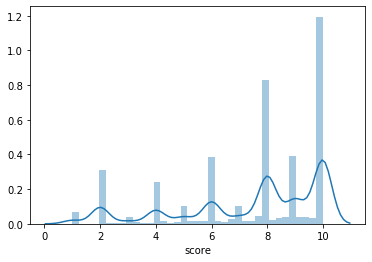

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.distplot(ytr)

plt.show()

############## Random Forest ##############

In [83]:
from sklearn.ensemble import RandomForestClassifier

#Random Forest классификатор
clf_rf = RandomForestClassifier()



In [86]:
ytr[:10]

0     4.0
1     6.0
2     9.0
3    10.0
4    10.0
5    10.0
6     3.0
7     6.0
8    10.0
9     2.0
Name: score, dtype: float64

In [106]:
from sklearn import utils
ytr1 = ytr.astype('int')
yval1 = yval.astype('int')
utils.multiclass.type_of_target(ytr1)

'multiclass'

In [97]:
ytr1[:10]

0     4
1     6
2     9
3    10
4    10
5    10
6     3
7     6
8    10
9     2
Name: score, dtype: int32

In [95]:
#классификатор 
clf_rf.fit(Xtr, ytr1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [96]:
y_pred=clf_rf.predict(Xtr)
y_pred[:10]

array([ 4,  6,  9, 10, 10, 10,  3,  6, 10,  2])

In [99]:
y_pred_v=clf_rf.predict(Xval)
y_pred_v[:10]

array([ 8, 10, 10, 10,  8, 10,  2,  8, 10, 10])

In [100]:
df = pd.DataFrame(list(zip(y_pred_v, yval)),
                                 columns = ['y_pred_v', 'yval'])
df.head(20)

,y_pred_v,yval
0,8,8.0
1,10,6.0
2,10,9.0
3,10,4.0
4,8,6.0
5,10,4.0
6,2,2.0
7,8,4.0
8,10,4.0
9,10,10.0


In [102]:
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(ytr1, y_pred)
print(accuracy)

0.9963419944839599


In [107]:
accuracy=accuracy_score(yval1, y_pred_v)
print(accuracy)

0.33089579524680074


In [104]:
from sklearn.metrics import classification_report

print(classification_report(ytr1, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       580
           2       1.00      1.00      1.00      2679
           3       1.00      1.00      1.00       506
           4       0.99      1.00      0.99      2281
           5       1.00      1.00      1.00      1235
           6       0.99      1.00      0.99      3643
           7       1.00      1.00      1.00      1538
           8       0.99      0.99      0.99      8026
           9       1.00      1.00      1.00      4175
          10       1.00      1.00      1.00      9782

    accuracy                           1.00     34445
   macro avg       1.00      1.00      1.00     34445
weighted avg       1.00      1.00      1.00     34445



In [108]:
print(classification_report(yval1, y_pred_v))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       323
           2       0.48      0.29      0.36      2226
           3       0.00      0.00      0.00       271
           4       0.20      0.01      0.02      1241
           5       0.00      0.00      0.00       274
           6       0.13      0.01      0.03      1626
           7       0.00      0.00      0.00       344
           8       0.25      0.36      0.30      2778
           9       0.12      0.03      0.04       439
          10       0.35      0.73      0.48      3606

    accuracy                           0.33     13128
   macro avg       0.15      0.14      0.12     13128
weighted avg       0.27      0.33      0.26     13128

